# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, inspired by the [Evol Instruct](https://arxiv.org/abs/2304.12244) paper.



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant

In [2]:
!pip install -qU pymupdf ragas

We'll need to provide our LangSmith API key, and set tracing to "true".

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

project_name = f"AIM - SDG - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_PROJECT"] = project_name
print(f"Project name: {project_name}")

Project name: AIM - SDG - a966db61


OpenAI's API Key!

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 2: Loading Source Documents

In order to create a synthetic dataset, we must first load our source documents!

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader

documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [ ]:
for doc in documents[:5]:
    print("\n",doc.page_content,"\n-------------------------------------------------\n")

## Task 3: Generate Synthetic Data

Let's first take a peek under the RAGAS hood to see what's happening when we generate a single example.

For simplicities sake - we'll look at a flow that results in a reasoning question.

### Two LLMs To Rule Them All

- `generator_llm` - will generate our seed questions and evolutions
- `critic_llm` - will act as a critic to verify if the evolutions are as we expect them to be

### Entering the Generation

We'll enter the generation process with our `generate_with_langchain_docs()` method - let's look at how that is implemented:

```python
def generate_with_langchain_docs(
    self,
    documents: t.Sequence[LCDocument],
    test_size: int,
    distributions: t.Optional[Distributions] = None,
    with_debugging_logs=False,
    is_async: bool = True,
    raise_exceptions: bool = True,
    run_config: t.Optional[RunConfig] = None,
):
    distributions = distributions or {}
    # chunk documents and add to docstore
    self.docstore.add_documents(
        [Document.from_langchain_document(doc) for doc in documents]
    )

    return self.generate(
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=with_debugging_logs,
        is_async=is_async,
        raise_exceptions=raise_exceptions,
        run_config=run_config,
    )
```

As you can see - before we do anything, our `doctore` is created using the provided `documents`.

Then, we move on to `generate()`, let's see how that works next!

### Generating Examples!

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/generator.py#L234), we'll work through the pseudo-code.

```python
function generate(test_size, distributions, other_params...):
    # Validate and set default values
    if distributions not provided:
        distributions = DEFAULT_DISTRIBUTION
    
    validate_distributions_sum_to_one(distributions)
    
    set_up_run_config()
    initialize_docstore()
    
    # Initialize evolutions
    for each evolution in distributions:
        initialize_evolution(evolution)
    
    set_up_debugging_logs_if_needed()
    
    # Set up execution environment
    executor = create_executor()
    
    # Get initial nodes
    current_nodes = get_random_nodes_from_docstore(test_size)
    
    total_evolutions = 0
    
    # Distribute evolutions based on probabilities
    for each evolution, probability in distributions:
        num_samples = round(probability * test_size)
        for i in random_sample(range(test_size), num_samples):
            submit_task_to_executor(evolution.evolve, current_nodes[i])
            total_evolutions += 1
    
    # Add filler evolutions if needed
    while total_evolutions < test_size:
        random_evolution = choose_random_evolution(distributions)
        submit_task_to_executor(random_evolution.evolve, current_nodes[total_evolutions])
        total_evolutions += 1
    
    # Get results
    try:
        test_data_rows = executor.get_results()
        if test_data_rows is empty:
            raise Exception("No results generated")

    return test_data_rows
```

In essence, we:

1. Do some validation of inputs, and initialize our evolutions.
2. Get some random nodes from our docstore.
3. Evolve the current nodes based on the desired distribution.
4. Fill with sampled evolutions if we're not at the desired number of rows.

### Peeking into the Complex Evolution Implementation for Reasoning Questions.

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L375). We'll work through the high-level implementation below.

Let's look into how the "Complex Evolution" is implemented:

1. First, we use [`_aevolve()`](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L289) to generate a "Seed Question".

```python
simple_question, current_nodes, _ = await self.se._aevolve(
            current_tries, current_nodes
        )
```

2. We use our provided `question_prompt` to generate a reasoning question.

```python
result = await self.generator_llm.generate(
            prompt=question_prompt.format(
                question=simple_question, context=merged_node.page_content
            )
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L15)):

```python
instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question."""
```

3. We verify the question is valid.

```python
is_valid_question, feedback = await self.question_filter.filter(
            reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L390))

```python
instruction="""
Asses the given question for clarity and answerability given enough domain knowledge, consider the following criteria:
1.Independence: Can the question be understood and answered without needing additional context or access to external references not provided within the question itself? Questions should be self-contained, meaning they do not rely on specific documents, tables, or prior knowledge not shared within the question.
2.Clear Intent: Is it clear what type of answer or information the question seeks? The question should convey its purpose without ambiguity, allowing for a direct and relevant response.
Based on these criteria, assign a verdict of "1" if a question is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. Assign "0" if it fails to meet one or more of these criteria due to vagueness, reliance on external references, or ambiguity in intent.
Provide feedback and a verdict in JSON format, including suggestions for improvement if the question is deemed unclear. Highlight aspects of the question that contribute to its clarity or lack thereof, and offer advice on how it could be reframed or detailed for better understanding and answerability.
"""
```

4. We [handle the question](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L401) if it's not valid, otherwise we compress the question:

```python
compressed_question = await self._transform_question(
            prompt=self.compress_question_prompt, question=reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L100))

```python
instruction="""Rewrite the following question to make it more indirect and shorter while retaining the essence of the original question.
    The goal is to create a question that conveys the same meaning but in a less direct manner. The rewritten question should shorter so use abbreviation wherever possible."""
```

5. Filter the newly compressed question based on a comparison to the original simple question.

```python
if await self.evolution_filter.filter(simple_question, compressed_question):
            # retry
            current_nodes = self.se._get_new_random_node()
            logger.debug(
                "evolution_filter failed, retrying with %s", len(current_nodes.nodes)
            )
            return await self.aretry_evolve(current_tries, current_nodes)
```

`filter` is implemented as follows, with our Critic LLM:

```python
    async def filter(self, simple_question: str, compressed_question: str) -> bool:
        prompt = self.evolution_elimination_prompt.format(
            question1=simple_question, question2=compressed_question
        )
        results = await self.llm.generate(prompt=prompt)
        results = results.generations[0][0].text.strip()
        results = await evolution_elimination_parser.aparse(results, prompt, self.llm)
        results = results.dict() if results is not None else {}
        logger.debug("evolution filter: %s", results)
        return results.get("verdict") == 1
```

Let's zoom back out now!



### Generating Answers:

For answer generation, we simply ask the LLM to answer the question we evolved using the context associated with our evolution - that's it!

We will this:

```python
class AnswerFormat(BaseModel):
    answer: str
    verdict: int
```

Using [this prompt](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L143):

```python
instruction="""Answer the question using the information from the given context. Output verdict as '1' if answer is present '-1' if answer is not present in the context."""
```

This uses our Generator LLM.

Actually creating our Synthetic Dataset is as simple as running the following cell!

In [7]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

#### ❓ **Question #1:**

What do the distributions do *specifically*?

> NOTE: More information is available [here](https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution) on the evolution distributions.

<span style="color:blue">
The distributions are used to indicate what fraction of questions in the final synthetic data set fall into each category. Using the distributions above, our final dataset will include:

- 50% simple questions
- 40% multi_context questions, which require information from multiple chunks to answer
- 10% reasoning questions, which are phrased in a way that require logical reasoning steps to answer

Since these specify the final distribution of our synthetic evaluation set, it's important that they add up to 1. The generator uses these to create a PDF to sample from as it evolves the question set.
</span>

Let's generate!

> NOTE: This cell will take some time, and also make a lot of calls to OpenAI's endpoints! You may run into rate-limits during this cell!

In [8]:
testset = generator.generate_with_langchain_docs(documents, 20, distributions, with_debugging_logs=True)

#### 🏗️ **Activity #1:**

Using the debugging logs above - trace through a single example of an evolution.

Mark which LLM (Generator, or Critic) was responsible for each step.

<span style="color:blue">

Ragas generally follows these steps:

1. Extracts and selects context chunks from documents using both context scoring and context relevancy metrics. These metrics gauge how well the selected context aligns with the question or topic being evaluated.
1. Generates keywords from these context chunks. These keywords help form the foundation for creating questions that focus on the most important elements within the context.
1. Generate a seed question from keywords
1. Iterate between the generator and critic, refining the quesiton until the critic accepts it.
Below is a full example trace.

---

Context Selection and Scoring 

`[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 3.0}`

Context Scoring: The system first selects and scores chunks of context based on metrics such as clarity, depth, structure, and relevance. In this example, the context received a high score of 3 across all metrics, meaning it is clear, detailed, well-structured, and relevant to the task.

---

Keyword Extraction 

`[ragas.testset.keywords.INFO] extracted keywords: ['Apple Inc.', 'non-current marketable securities', 'fair value', 'September 30, 2023']`

Keyword Extraction: After selecting and scoring the context, the system extracts important key phrases or keywords such as "Apple Inc.," "non-current marketable securities," "fair value," and "September 30, 2023." These keywords are crucial for generating a relevant and meaningful seed question.

---

Seed Question Generation 

`[ragas.testset.evolutions.INFO] seed question generated: What is the total fair value of the Company's non-current marketable securities as of September 30, 2023?`

Generator LLM: Initially creates this seed question based on keywords and key phrases extracted from thecontext. In this case, key terms like "fair value," "non-current marketable securities," and "September 30, 2023" were identified from the document and used to generate this seed question.

---

`First Evaluation by Critic LLM`

`[ragas.testset.filters.DEBUG] filtered question: {'feedback': "The question asks for the total fair value of the company's non-current marketable securities as of a specific date (September 30, 2023). It specifies the type of financial asset and the date, but it assumes access to specific financial data or reports that are not provided within the question itself. To improve clarity and answerability, the question could specify the company or provide a brief context about the financial data source, or it could be rephrased to ask for general information about how to determine the fair value of non-current marketable securities.", 'verdict': 0}`

Critic LLM: Evaluates the clarity and relevance of the generated seed question against the context. Here, it points out that the question lacks necessary details about which company is being referenced. The Critic suggests improvements based on the context and extracted keywords.

---

`First Revision by Generator LLM`

`[ragas.testset.evolutions.INFO] rewritten question: What is the total fair value of the Company's non-current marketable securities as of September 30, 2023?`

Generator LLM: Attempts a revised version of the question, but the changes are minimal. The Generator LLM hasn't yet fully integrated the feedback from the Critic, so the question remains largely unchanged.

---

Second Evaluation by Critic LLM

`[ragas.testset.filters.DEBUG] filtered question: {'feedback': "The question asks for the total fair value of a company's non-current marketable securities as of a specific date, but it still lacks context or specificity regarding the company. To improve clarity and answerability, the question could specify which company or provide brief context about the financial data source.", 'verdict': 0}`

Critic LLM: Once again, the Critic identifies the missing information and suggests adding the specific company name to the question, referencing the key terms and context.`

---

Second Revision by Generator LLM

`[ragas.testset.evolutions.INFO] rewritten question: What is the total fair value of Apple Inc.'s non-current marketable securities as of September 30, 2023?`

Generator LLM: Incorporates the keyword "Apple Inc." as a specific company, which was extracted from the context. This ensures the question is now aligned with the context and key phrases.

---

Final Evaluation by Critic LLM

`[ragas.testset.filters.DEBUG] filtered question: {'feedback': 'The question is now clear and specific, asking for a financial figure related to Apple Inc. and its non-current marketable securities. The inclusion of the company name and a clear date makes it answerable based on relevant financial data. Verdict: 1 (Accepted).'}`

Critic LLM: After evaluating the revised question, it accepts the question because it now fully utilizes the context and key phrases, making it clear, relevant, and answerable.
</span>

In [10]:
pd_testset = testset.to_pandas()
pd_testset.to_csv("testset.csv") # Save it for later in case we need to re-run the notebook

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [11]:
from langsmith import Client

client = Client()

dataset_name = "Apple 10-Q Filing Questions - v3"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Apple's 10-Q Filing"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [12]:
for test in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": test[1]["question"]
      },
      outputs={
          "answer": test[1]["ground_truth"]
      },
      metadata={
          "context": test[0]
      },
      dataset_id=dataset.id
  )

## Basic RAG Chain

Time for some RAG!

We'll use the Apple 10-Q filing as our data source today!


In [13]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [15]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [16]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q"
)

In [17]:
retriever = vectorstore.as_retriever()

To get the "A" in RAG, we'll provide a prompt.

In [18]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [20]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [21]:
rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"I don't know."

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [22]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [23]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        }
    }
)

#### 🏗️ **Activity #2:**

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

<span style="color:blue">

- **qa_evaluator**: The LangChainStringEvaluator with the "qa" configuration measures the correctness of a language model's response in question-answering (QA) scenarios. It compares the predicted answer to a reference answer (if available) and evaluates whether the response is correct based on the input query. It returns correct / incorrect.

- **labeled_helpfulness_evaluator**: This custom metric votes on whether the answer is helpful, taking into account the ground truth / reference answer as a guide. An answer could be factually correct without being useful or helpful, so this helps us understand whether the system's answers will actually be helpful to users. It returns Yes or No.

- **dope_or_nope_evaluator**: This custom metric asks whether the answer is "dope, lit, or cool". It'll return Yes if the answer is any of those adjectives, and No if it isn't. This helps us understand how many of the system's answers are dope.
</span>

## LangSmith Evaluation

In [24]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain"},
)

View the evaluation results for experiment: 'fresh-beauty-59' at:
https://smith.langchain.com/o/4d0f712c-8cdf-50b5-b27c-47e2afd70138/datasets/5605b699-7ef2-4c51-85c5-261354072894/compare?selectedSessions=3b941682-2909-4653-89de-1b41a632d29d




0it [00:00, ?it/s]

<ExperimentResults fresh-beauty-59>

<span style="color:blue">
Our initial average results from the baseline run are:

- 65% correct
- 24% dope
- 59% helpful
</span>

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [34]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool! Your answers must be helpful and correct too. 
Don't use emojis.

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [26]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [27]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓**Question #2:**

Why would modifying our chunk size modify the performance of our application?

<span style="color:blue">
Changing the chunk size can affect both accuracy and latency in RAG systems.


**Accuracy**:

- **Context completeness**: Chunks that are too short may not provide enough information for the model to generate accurate or meaningful answers, as the model might miss critical context. However, if the chunks are too long, they could introduce noise by including irrelevant information, reducing the accuracy of the retrieval and making it harder for the model to focus on the relevant details. This can degrade both the quality of the embeddings generated for retrieval and the LLM’s ability to formulate concise and correct answers.

- **Embedding efficiency**: Long chunks are harder to represent effectively within a fixed-size vector, which can lead to embeddings that fail to capture the full complexity or nuance of the content. This is particularly true in vector databases where each chunk is converted to a single embedding representation. Chunk size must balance the trade-off between being long enough to be meaningful but short enough to be embedded accurately.

**Latency:**

- **Database retrieval**: Larger chunks take more time to retrieve from the database, increasing latency. 

- **LLM processing time**: The longer the chunk, the more time the LLM will need to process and understand the information, especially if there are irrelevant details. Smaller, well-targeted chunks allow the LLM to efficiently process the relevant information without getting bogged down by unnecessary content.

**Additional factors**:

- **Token limits**: Many LLMs have token limits, and longer chunks might push the input beyond these limits, which can cause truncation or prevent the inclusion of all necessary context.

In summary, optimizing chunk size is crucial for balancing accuracy and performance in RAG systems. Small changes to chunk size can affect accuracy and latency a bit, and large changes to chunk size will affect it a lot.
</span>

In [28]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓**Question #3:**

Why would modifying our embedding model modify the performance of our application?

<span style="color:blue">
Modifying the embedding model can affect both accuracy and latency in your RAG system.

**Accuracy**:

- **Model sophistication**: The quality of the base embedding model (pre-trained and/or fine-tuned) directly impacts the ability to capture semantic nuances in the data. More advanced models (e.g., fine-tuned models on specific domain data) tend to capture finer details and relationships between concepts, which results in more accurate retrieval of context and better answers from the language model. A less sophisticated model might miss these nuances and retrieve less relevant context, reducing the overall performance of the application. Note that "quality" is relative to the use case. A high quality model fine-tuned for medical data may not be useful if I want a model to encode sports trivia.
- **Vector dimensionality**: Embedding models vary in their vector size, which determines how much information can be encoded. Higher-dimensional vectors can capture more detailed semantic information, which can improve the ability to retrieve the most relevant chunks of context for a given query. However, too many dimensions can sometimes introduce noise, leading to less optimal retrieval results.

**Latency**:

- **Model size and complexity**: Larger embedding models with more parameters generally require more time to compute embeddings. This results in higher latency during the embedding stage. On the other hand, smaller models may produce embeddings faster but may not capture as much detail, creating a trade-off between speed and retrieval quality.
- **Vector length and similarity searc**h: Longer vectors not only take more time to generate but also increase the computational cost of searching through the vector space during retrieval. When dealing with high-dimensional vectors, search can become slower, leading to increased system latency. 

For these reasons, the choice of embedding model can have a big impact on the end system.
</span>

In [29]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q (Augmented)"
)

In [30]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [35]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [36]:
dope_rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"Looking at the numbers, Apple is flexing some solid financial muscle here. They've got a healthy cash flow, with net income hitting $79 billion for the nine months ended June 29, 2024, which is an increase from the previous year. Plus, their total assets are still substantial at $331.6 billion, even though they've seen a dip from the previous quarter.\n\nTheir gross margin is also looking good at $136.8 billion for the nine months, and operating income is up too. While their current liabilities are a bit high, their cash and cash equivalents still sit comfortably at $25.6 billion. So yeah, it seems like Apple is riding the wave of financial health pretty well. They're not just surviving; they're thriving."

Finally, we can evaluate the new chain on the same test set!

In [37]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'warm-bibliography-51' at:
https://smith.langchain.com/o/4d0f712c-8cdf-50b5-b27c-47e2afd70138/datasets/5605b699-7ef2-4c51-85c5-261354072894/compare?selectedSessions=7257240e-091f-4e7d-b2bb-cc5b0c8884a2




0it [00:00, ?it/s]

<ExperimentResults warm-bibliography-51>

<font color="blue">Our results from this run are:
- 80% correct
- 35% dope
- 75% helpful

#### 🏗️ **Activity #3:**

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

<span style="color:blue">
By changing the embedding model, prompt, and chunk size, we were able to increase correctness (65% -> 80%), dopeness (24% -> 34%), and helpfulness (60% -> 75%). At the same time, the average time per question went up (1.39s -> 1.57s).

This isn't a high quality experiment, because we changed too much stuff. It's a much better practice to vary one item at a time so that it's easier to tell which effects relate to which change. However, I would imagine that:

The correctness and helpfulness improvements likely relate to our larger chunk size and better embedding model. If the LLM doesn't have the context it needs to answer, it won't produce correct or helpful output. By improving the search results and giving the model more context, it is more likely to produce correct responses that are useful to the user.

The prompt changes probably helped the dopeness go up. If we don't tell the system to be dope, it won't respond in a dope tone. However, this metric is still quite low - likely because we haven't defined dopeness very well either in the prompt or in the evaluation. By defining dopeness as "dope, cool, or lit" (all slang terms with debateable meanings), we haven't given either the RAG system or the evaluator much to go on. To improve dopeness, we probably need to be more specific here.

The latency increase is likely due to the longer chunk size - as mentioned above, longer chunks can take longer to retrieve and longer for the LLM to parse when answering. However, it could also be due to the embedding model changes. As discussed in an earlier answer, longer embeddings can increase latency. By default, text-embedding-3-small produces embeddings with a vector length of 1536, whereas text-embedding-3-large has a default vector length of 3072. Although the user has the option to use a shorter vector length with these models if desired, we used the defaults.
</span>

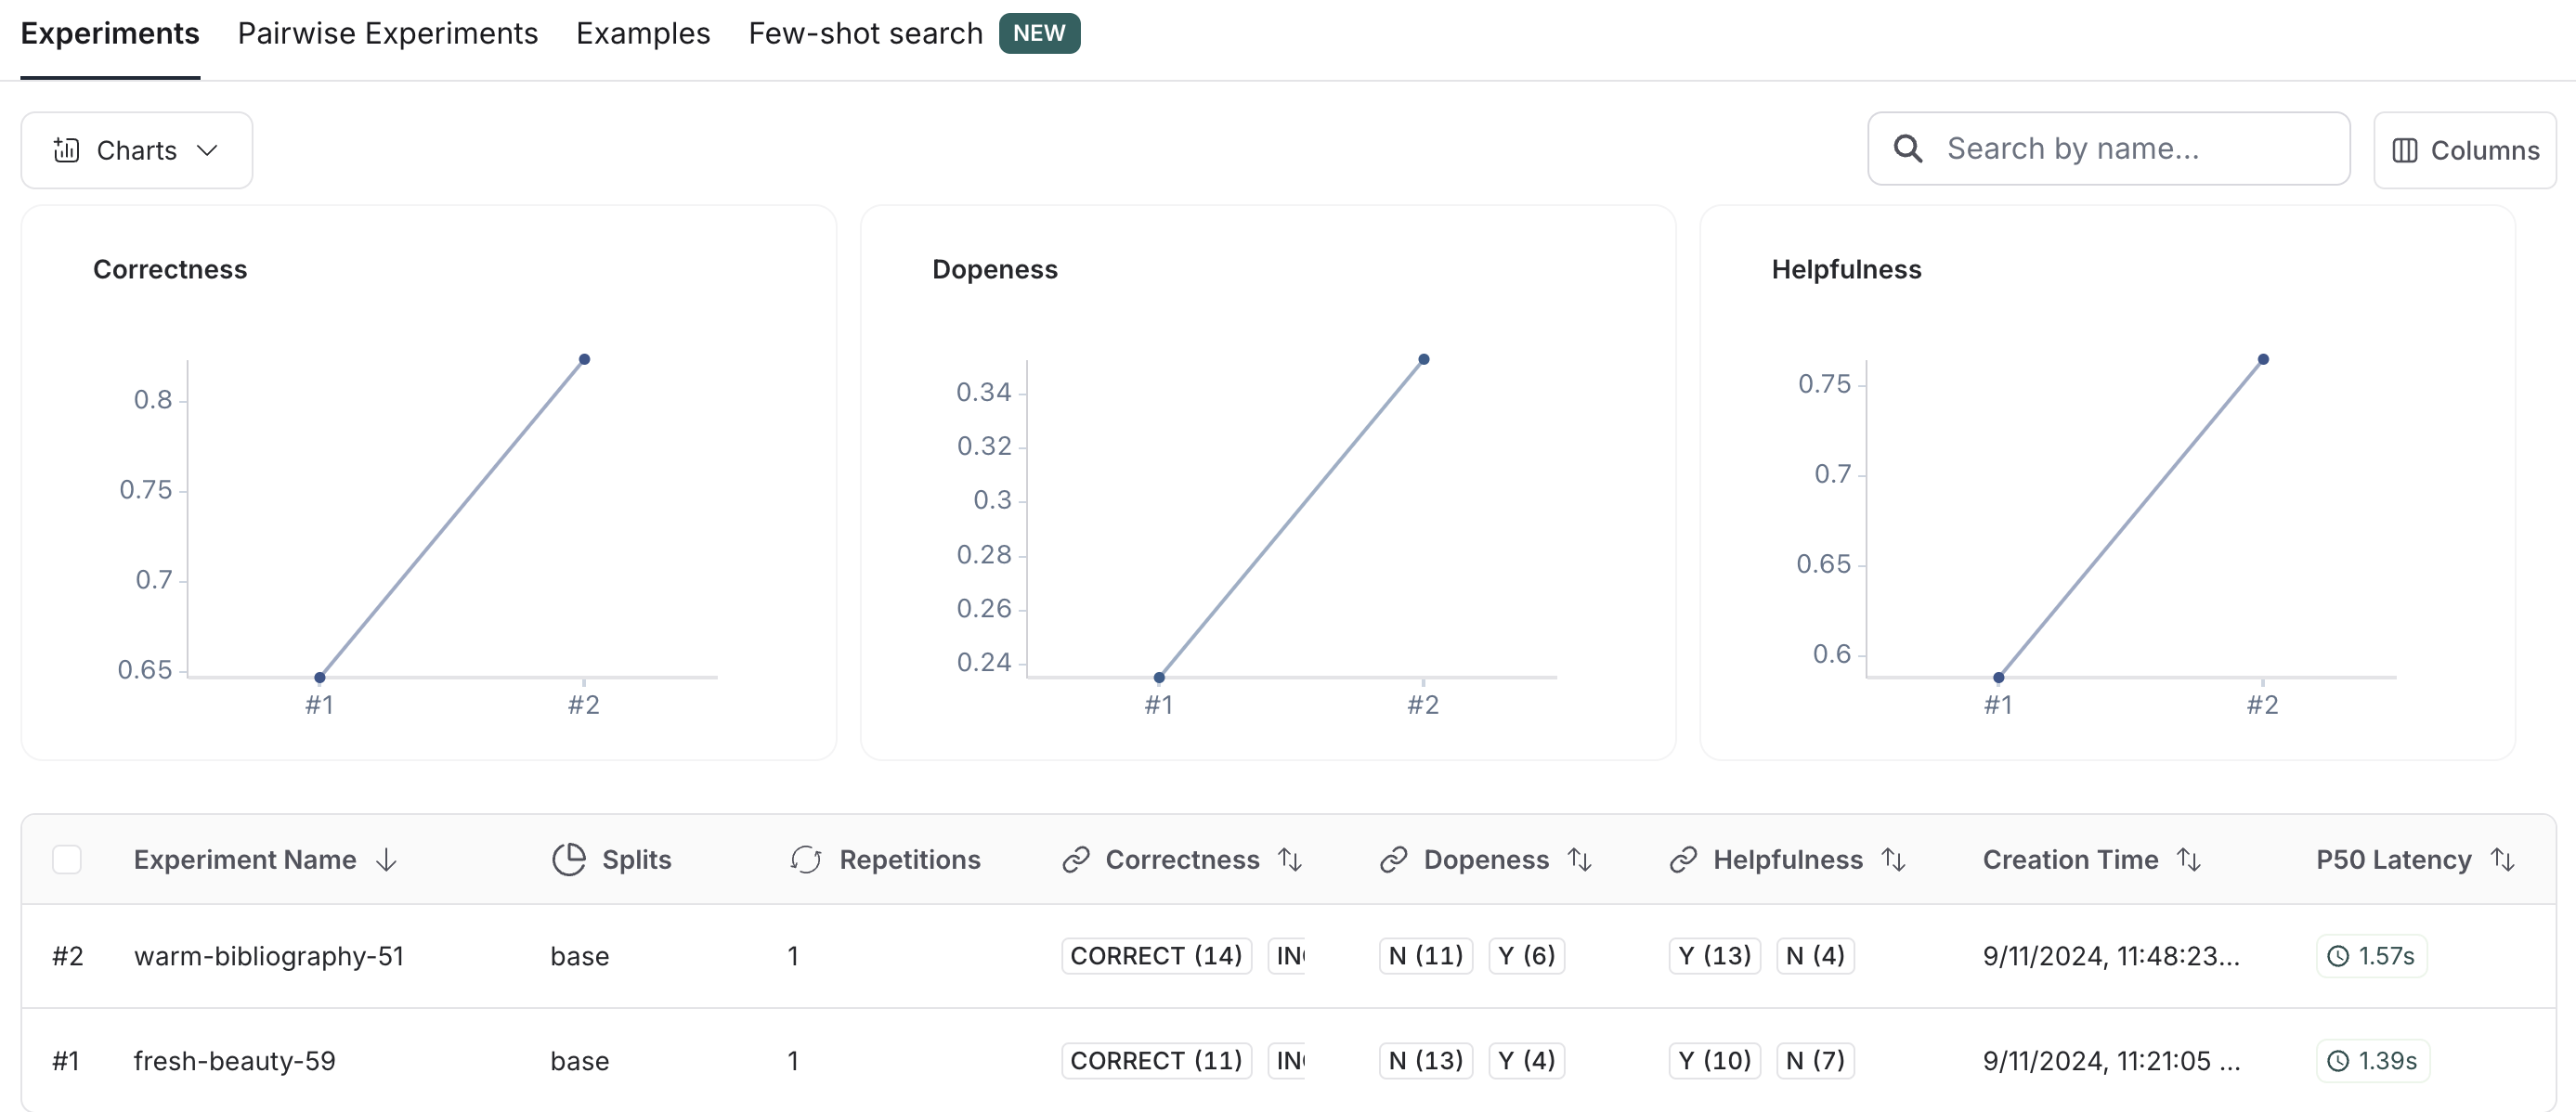

In [38]:
from IPython.display import Image
Image("results.png")